## <font color=#B2D732> <span style="background-color: #4424D6">   Spinal Cord fMRI preprocessing </font>
____________________________________________________

### Project: Spine_7T
____________________________________________________
@ author: Caroline Landelle, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com
July 2025

<font color=#4424D6> **Description:** </font>  
This notebook provides code for preprocessing fMRI data of spinal cord acquisition at 7T. 

<font color=#4424D6>  **Toolbox required:** </font> 
> SpinalCordToolbox  
> FSL (Python)  

____________________________________________________

<font color=#B2D732> *nb:*</font> *The Philipps system includes additional "dummy scans" at the beginning of the acquisition to allow the magnetization to stabilize to a steady state. The dummy scans are not stored, so they will make the banging sound like normal scans but there will be no data associated with them.*     


## <font color=#B2D732> <span style="background-color: #4424D6"> Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

verbose=True
import sys, json, glob, os, shutil
import pandas as pd
from IPython.display import Image, display

# Load config file ------------------------------------------------------------
# The config file should be first review and all path should be modified (lines: )
with open('../config/config_preprocess_spine7T.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified

#import scripts
sys.path.append(config["root_dir"] + config["tools_dir"]["main_codes"] + "/code/") # Change this line according to your directory

from brsc_preprocess import Preprocess_BrSc, Preprocess_Sc
import brsc_utils as utils
#Initialize codes
preprocess_BrSc=Preprocess_BrSc(config) # initialize the function

preprocess_Sc=Preprocess_Sc(config) # initialize the function
ses_name=""


#----- Select specificity for each individuals
design_exp={}
for ID in config["participants_IDs"]:
    design_exp[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            design_exp[ID]["task-" + task_name + "_acq-" + acq_name]=[]
            tag="task-" + task_name + "_acq-" + acq_name
        
            if tag in config.get("files_specificities", {}).get("func", {}).get(ID,{}):
                for run_name in config["files_specificities"]["func"][ID][tag]:
                    design_exp[ID][tag].append(run_name)
    
            else:
                for run_name in config["design_exp"]["run_names"][tag]:
                    design_exp[ID][tag].append(run_name)
        

participants_tsv = pd.read_csv('../config/participants.tsv', sep='\t')


The config files should be manually modified first
All the raw data should be store in BIDS format
 
sub-100 have a func filename specitity: 
{'task-motor_acq-shimSlice+3mm': ['']}
100
/cerebro/cerebro1/dataset/spine_7T/derivatives/spine_7T_project/preprocessing/nov25/sub-100/


## <font color=#B2D732> <span style="background-color: #4424D6"> A/ Spinal cord preprocessing
### <font color=#4424D6> I. Select raw data </font >

In [2]:
raw_func=[];json_f=[]
raw_anat=[];# will contain the output filename for all participants.
json_f={};raw_func={}
derivatives_dir=config["root_dir"] + config["derivatives_dir"]
for ID_nb,ID in enumerate(config["participants_IDs"]):
    json_f[ID]={}; raw_func[ID]={}

    #------ Select anat data (raw data were copied in the preprocess dir)
    run_tag = config["files_specificities"]["T2s"][ID] if ID in config.get("files_specificities", {}).get("T2s", {}) else ""
    raw_anat.append(glob.glob(derivatives_dir + config["preprocess_dir"]["main_dir"].format(ID) + "/anat/" + config["preprocess_f"]["anat_raw"].format(ID,""))[0])

    #------ Select func data
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            json_f[ID][tag]=[];raw_func[ID][tag]=[]
            if tag in config.get("files_specificities", {}).get("func", {}).get(ID,{}):
                for run in config["files_specificities"]["func"][ID][tag]:
                    json_f[ID][tag].append(glob.glob(config["root_dir"]+config["raw_dir"] + "sub-" + ID+  "/func/sub-" + ID +  "_" +tag + "_" +run+ "*.json")[0])
                    raw_func[ID][tag].append(glob.glob(config["root_dir"]+config["raw_dir"] + "sub-" + ID+  "/func/sub-" + ID + "_" + tag + "_" +run+ "*.nii.gz")[0])

            else:
                for run in config["design_exp"]["run_names"][tag]:
                    json_file=glob.glob(config["root_dir"]+config["raw_dir"] + "sub-" + ID+  "/func/sub-" + ID + "_" + tag + "_" +run+ "*.json")
                    func_file=glob.glob(config["root_dir"]+config["raw_dir"] + "sub-" + ID+  "/func/sub-" + ID + "_" + tag + "_" +run+ "*.nii.gz")
                    if json_file:
                        json_f[ID][tag].append(json_file[0])
                    if func_file:
                        raw_func[ID][tag].append(func_file[0])


      

## <font color=#B2D732> <span style="background-color: #4424D6"> A/ Spinal cord preprocessings

### <font color=#4424D6> I. Motion correction </font >
#### <font color=#4424D6> I.a Calculate the mean func image and create surronding mask </font > 
> - the centerline of the spinal cord was automatically extracted from the mean image or can be draw manually when it is necessary (manual=True), for manual step you should start at the very first slice, otherwise the mask and the mean func image size will differ
> - A cylindrical mask with a diameter of 25 mm is drawn along this centerline and further used to exclude regions outside the spinal cord from the motion correction procedure, as those regions may move independently from the cord.   

<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  Requiered visual check and sometime manual processes  </span> 

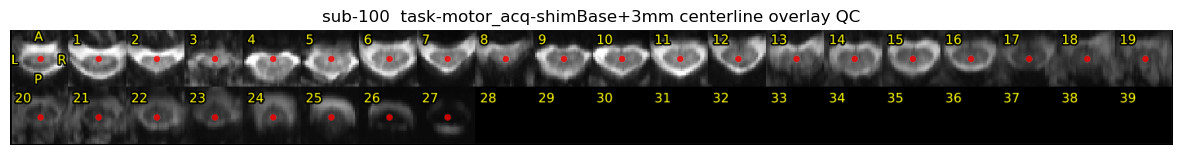

If manual corrections are needed, set:
manual=True, redo_ctrl=True, redo_mask=True
⚠ Ensure the centerline starts at the first slice.


In [3]:
mean_func_f={};mask_sc_files={};ctrl_sc_files={}
for ID_nb, ID in enumerate(config["participants_IDs"]):
    mean_func_f[ID]={};mask_sc_files[ID]={};ctrl_sc_files[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            mean_func_f[ID][tag]=[];mask_sc_files[ID][tag]=[];ctrl_sc_files[ID][tag]=[]
            for run_nb,run_name in enumerate(design_exp[ID][tag]):
                o_dir=derivatives_dir+config["preprocess_dir"]["main_dir"].format(ID)+  "/func/" +tag + '/'
                o_img=o_dir +  os.path.basename(raw_func[ID][tag][run_nb]).split(".")[0] + "_tmean.nii.gz"
                mean_func_f[ID][tag].append(utils.tmean_img(ID=ID,i_img=raw_func[ID][tag][run_nb],o_img=o_img,verbose=False))
                ctrl_sc_files_, mask_sc_files_=preprocess_Sc.moco_mask(ID=ID,i_img=mean_func_f[ID][tag][run_nb],
                                                                       radius_size=25,task_name=tag,
                                                                       manual=False,
                                                                       redo_ctrl=False,
                                                                       redo_mask=False,
                                                                       verbose=verbose)
                mask_sc_files[ID][tag].append(mask_sc_files_)
                ctrl_sc_files[ID][tag].append(ctrl_sc_files_)


#### <font color=#4424D6> I.a Calculate moco </font > 
to check: moco params brsc_preprocess.py line 269, could be enter manually: preprocess_Sc.moco(params="poly=1")

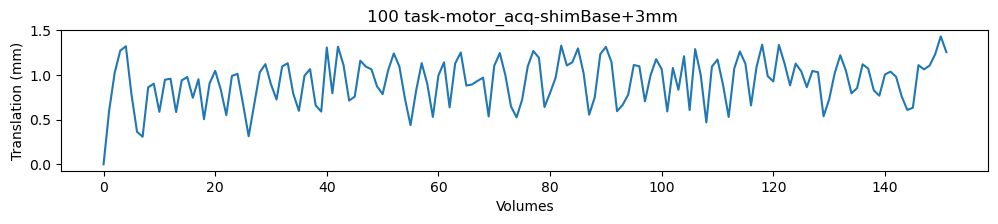

sub-100 Diff_XY: 0.262 mm


In [4]:
moco_f={};moco_mean_f={};
# clean you remporary folder between each individuals if your memory crash:
#string='find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;' ; os.system(string)
#string='find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;'; os.system(string)

for ID_nb, ID in enumerate(config["participants_IDs"]):
    moco_f[ID]={};moco_mean_f[ID]={};
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            moco_f[ID][tag]=[];moco_mean_f[ID][tag]=[];
            for run_nb,run_name in enumerate(design_exp[ID][tag]):
                print(run_name)
                params = 'poly=0,smooth=1,metric=MeanSquares,gradStep=1,sampling=0.2'
                moco_f_,moco_mean_f_,qc_dir=preprocess_Sc.moco(ID=ID,i_img=raw_func[ID][tag][run_nb],mask_img=mask_sc_files[ID][tag][run_nb],
                                                        task_name=tag,run_name=run_name,params=params,
                                                               verbose=verbose,
                                                               redo=False)
                moco_f[ID][tag].append(moco_f_)
                moco_mean_f[ID][tag].append(moco_mean_f_)

                #if verbose:
                 #   display(Image(filename=qc_dir +  "/background_img.gif")) # don't display for github
                    


### <font color=#4424D6> II. Segmentation </font >

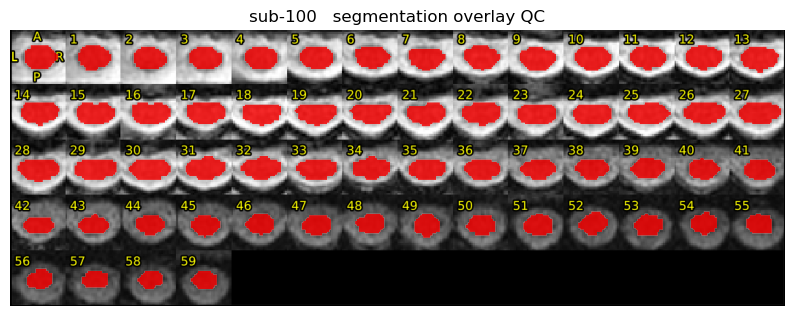

/!\ Manual segmentation file detected — using it as output.


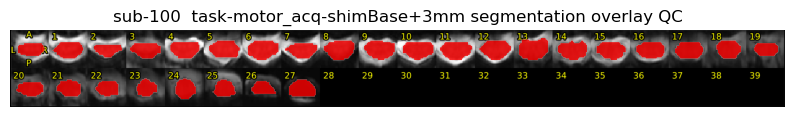

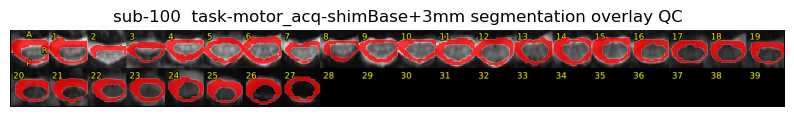

In [5]:
seg_anat_sc_files=[];seg_func_sc_files={} ; csf_func_files={}

for ID_nb, ID in enumerate(config["participants_IDs"]):

    # segementation of the t2s
    seg_anat_sc_files.append(preprocess_Sc.segmentation(ID=ID,
                                                        i_img=raw_anat[ID_nb],
                                                        img_type="anat",
                                                        contrast_anat="t2",
                                                        redo=False,
                                                        redo_qc=False, # should be true if you have done manual correction
                                                        verbose=verbose))
    # segmentation of the EPIs
    seg_func_sc_files[ID]={}; csf_func_files[ID]={}
    for task_name in config["design_exp"]["task_names"]:
        for acq_name in config["design_exp"]["acq_names"]:
            tag="task-" + task_name + "_acq-" + acq_name
            seg_func_sc_files[ID][tag]=[]; csf_func_files[ID][tag]=[]
            for run_nb,run_name in enumerate(design_exp[ID][tag]):
                seg_func_sc_files[ID][tag].append(preprocess_Sc.segmentation(ID=ID,
                                                                             i_img=moco_mean_f[ID][tag][run_nb],
                                                                              task_name=tag,
                                                                             img_type="func",
                                                                             mask_qc=mask_sc_files[ID][tag][run_nb],
                                                                             redo=False,
                                                                             redo_qc=False, # should be true if you have done manual correction
                                                                             verbose=verbose))
                
                preprocess_Sc.segmentation(ID=ID,
                                           i_img=moco_mean_f[ID][tag][run_nb],
                                           task_name=tag,contrast_anat="t2s",
                                           img_type="func", 
                                           tissue="csf",
                                           redo_qc=False, # should be true if you have done manual correction
                                           redo=False,
                                           verbose=verbose)
            


### <font color=#4424D6> III. Labeling of the inter vertebral disk </font >
If their is a mismatch in vertebral labeling use auto=False 

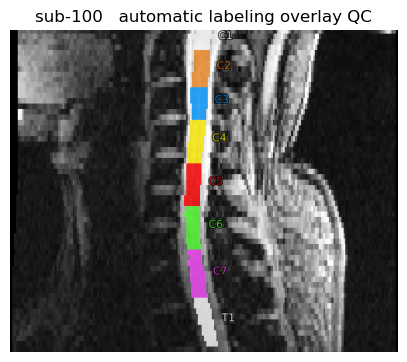

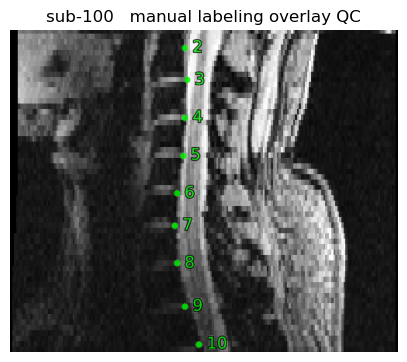

In [6]:
vert_labels_files=[]; 
for ID_nb, ID in enumerate(config["participants_IDs"]):
    for auto in [True,False]:
        if auto:
            id_info = participants_tsv.loc[participants_tsv['participant_id'] == int(ID), ['anat_disc_ref','anat_disc_ref_z']]
            vert= id_info['anat_disc_ref'].iloc[0][-1]
            z_value = id_info['anat_disc_ref_z'].iloc[0]

        vert_labels_files.append(preprocess_Sc.label_vertebrae(ID=ID,
                                                               i_img=raw_anat[ID_nb],
                                                               seg_img=seg_anat_sc_files[ID_nb],
                                                               c="t2",
                                                               initz=f"{z_value},{vert}",auto=auto,
                                                               redo=False,
                                                               verbose=verbose))



### <font color=#4424D6> IV. Coregistration to PAM50 template </font >
#### <font color=#4424D6> IV.a Coregistration between anat image and PAM50 </font > 

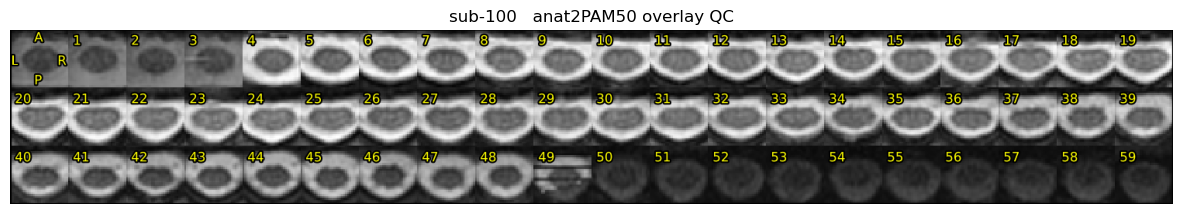

In [7]:
warpT2w_PAM50_files=[]; # will contain the output filename for all participants.
dir_manual=derivatives_dir +"/manual/sub-{}/anat/"
seg_anat_sc_final_file=[]
for ID_nb, ID in enumerate(config["participants_IDs"]):
    manual_file=dir_manual.format(ID,ID) + os.path.basename(seg_anat_sc_files[ID_nb]) 
    seg_anat_sc_final_file.append(manual_file if os.path.exists(manual_file) else seg_anat_sc_files[ID_nb])
    param = "step=1,type=seg,algo=centermassrot:step=2,type=im,algo=syn,iter=5,slicewise=1,metric=CC,smooth=0"
    warpT2w_PAM50_files.append(preprocess_Sc.coreg_anat2PAM50(ID=ID,
                                                              i_img=raw_anat[ID_nb],
                                                              seg_img=seg_anat_sc_files[ID_nb],
                                                              labels_img=vert_labels_files[ID_nb],
                                                          img_type="t2",
                                                              tag='anat',
                                                              param=param,
                                                          redo=False,
                                                              verbose=verbose))

#### <font color=#4424D6> IV.b Coregistration between func image and PAM50 </font > 

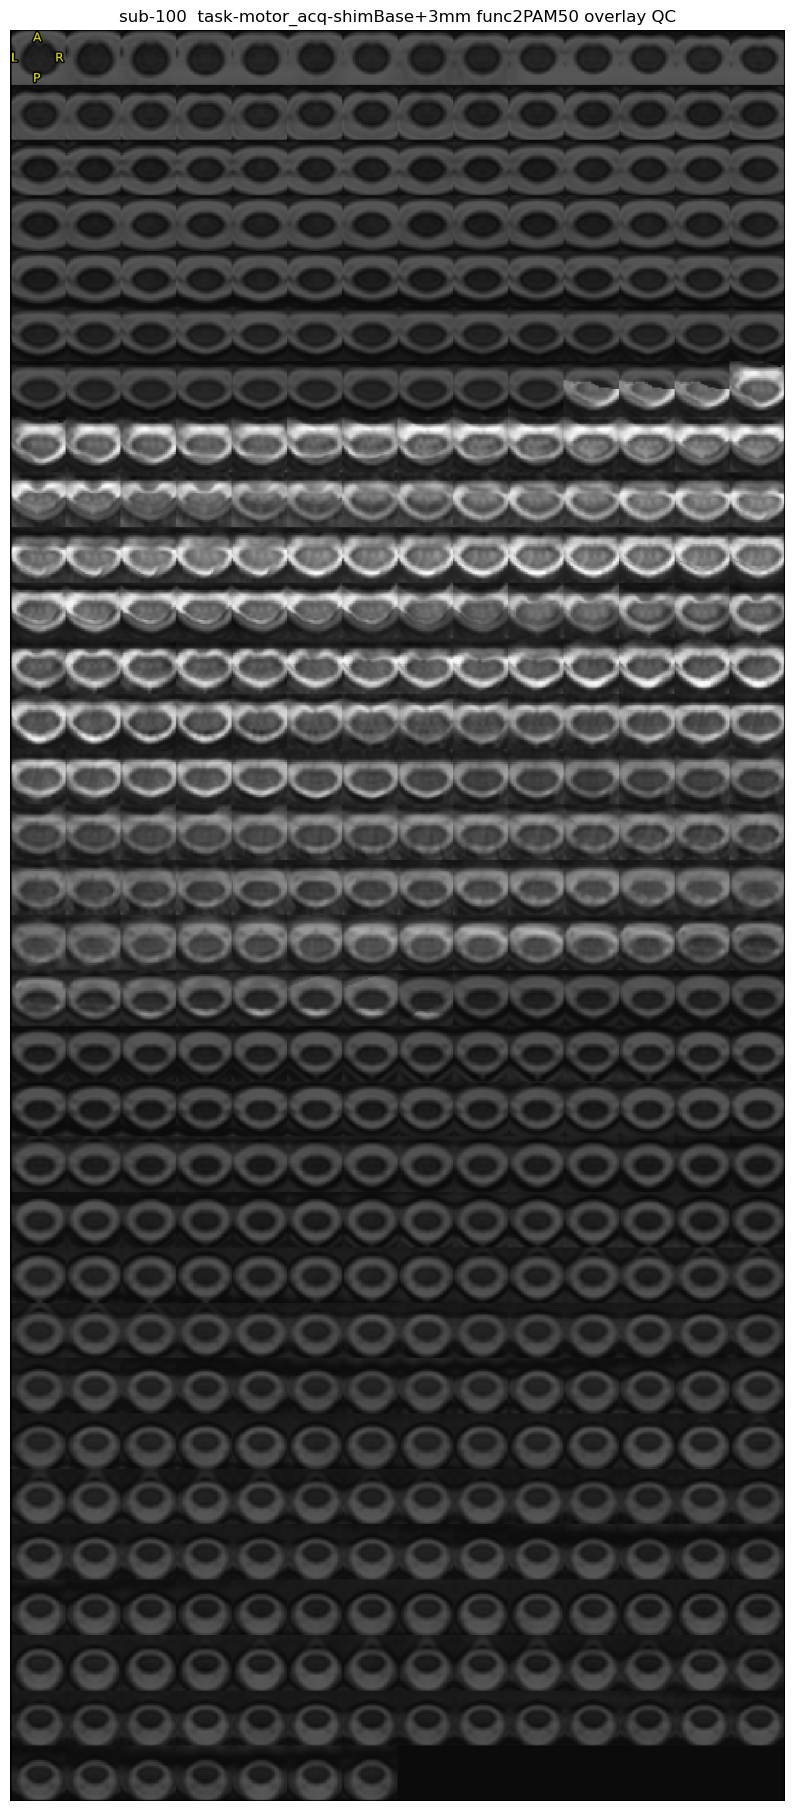

In [8]:
func2PAM50_dir={}; func2PAM50_f={}; warp_func2PAM50={}

for ID_nb, ID in enumerate(config["participants_IDs"]):
    func2PAM50_dir[ID]={}; func2PAM50_f[ID]={};warp_func2PAM50[ID]={}
    for task_name in design_exp[ID]:
        func2PAM50_dir[ID][task_name]=[];func2PAM50_f[ID][task_name]=[];warp_func2PAM50[ID][task_name]=[]
        param="step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=syn,metric=CC,iter=3,slicewise=1"

        for run_nb,run_name in enumerate(design_exp[ID][task_name]):
            func2PAM50_dir_=preprocess_Sc.coreg_img2PAM50(ID=ID,
                                                          i_img=moco_mean_f[ID][task_name][run_nb],
                                                          i_seg=seg_func_sc_files[ID][task_name][run_nb],
                                                          task_name=task_name,run_name=run_name,
                                                          initwarp=warpT2w_PAM50_files[ID_nb][1],
                                                          initwarpinv=warpT2w_PAM50_files[ID_nb][0],
                                                          param=param,
                                                          redo=False,
                                                          verbose=verbose)
                
